## Income Qualification Project

Identify the level of income qualification needed for the families in Latin America.

### Problem Statement Scenario
Many social programs have a hard time making sure the right people are given enough aid. It’s tricky when a program focuses on the poorest segment of the population. This segment of population can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, a popular method called Proxy Means Test (PMT) uses an algorithm to verify income qualification. With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling or the assets found in their homes to classify them and predict their level of need. While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

The Inter-American Development Bank (IDB) believes that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

#### We start by importing the needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

### Importing Data Sets

In [2]:
income_train = pd.read_csv('train.csv')
income_test = pd.read_csv('test.csv')

In [3]:
# View the train set
income_train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Q1. Identify the output variable.

In [4]:
for i in income_train.columns:
    if i not in income_test.columns:
        print("Our Target variable is {}".format(i))

Our Target variable is Target


In [5]:
income_train.Target.unique()

array([4, 2, 3, 1], dtype=int64)

As there are 4 unique values of the target column, this problem statement is of Supervised Learning - Classification

## Q2 - Understand the type of data

In [6]:
print('Train Set Shape :', income_train.shape)
print('Test Set Shape :', income_test.shape)

Train Set Shape : (9557, 143)
Test Set Shape : (23856, 142)


In [7]:
print(income_train.dtypes.value_counts())

int64      130
float64      8
object       5
dtype: int64


In [8]:
income_train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,1.036574,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,2.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000
max,2.353477e+06,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,8.000000,...,441.000000,9409.000000,169.000000,441.000000,81.000000,36.000000,64.000000,1369.000000,9409.000000,4.000000


From the above table we see that there are 138 numeric columns & remaining 6 categorical columns.

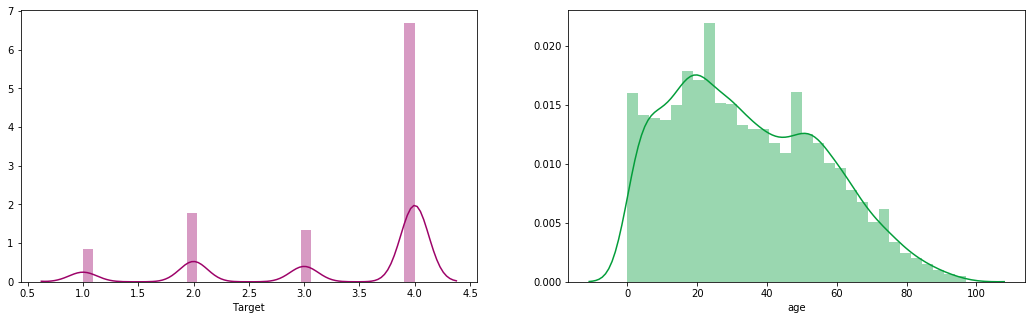

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))
sns.distplot(income_train['Target'],color='#9D0369', ax=axes[0])
sns.distplot(income_train['age'],color='#039D3A', ax=axes[1]);

## Q4. Check whether all members of the house have the same poverty level.

In [10]:
# 'idhogar' column = Household level identifier 

unique_values = income_train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
different_households = unique_values[unique_values != True]
print('There are {} households where the family members do not all have the same target.'.format(len(different_households)))

There are 85 households where the family members do not all have the same target.


In [11]:
income_train[income_train['idhogar'] == different_households.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


## Q5. Check if there is a house without a family head.

In [12]:
check_leader = income_train.groupby('idhogar')['parentesco1'].sum()

#Check for head
no_head = income_train.loc[income_train['idhogar'].isin(check_leader[check_leader == 0].index), :]
print('There are {} households without a head.'.format(no_head['idhogar'].nunique()))

There are 15 households without a head.


In [13]:
# Check for households with no heads but have different labels.

no_head_equal = no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(no_head_equal == False)))

0 Households with no head have different labels.


There is no household which has no head and the family members have different labels.

## Q6. Set the poverty level of the members and the head of the house same in a family
So given that we identified households which do not have a head however their family members have the same label. SO let's fix it by making sure that every family member in the same family has a common target variable.

In [14]:
for each_household in different_households.index:
    
    #find the correct label
    true_target = int(income_train[(income_train['idhogar'] == each_household) & (income_train['parentesco1'] == 1.0)]
                      ['Target'])
    
    #assign the correct label for each member
    income_train.loc[income_train['idhogar'] == each_household, 'Target'] = true_target

unique_values = income_train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
different_households = unique_values[unique_values != True]
print('There are {} households where the family members do not all have the same target.'.format(len(different_households)))

There are 0 households where the family members do not all have the same target.


### Combining both data sets

#### For Futher feature engineering we can combine the train & test data set so that we do not repeat the same steps for both sets

In [15]:
income_train['source'] = 'income_train'
income_test['source'] = 'income_test'

new_df = pd.concat([income_train, income_test], ignore_index=True)
print(income_train.shape, income_test.shape, new_df.shape)

(9557, 144) (23856, 143) (33413, 144)


## Q7. Count how many null values are existing in columns

In [16]:
null_counts = new_df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

rez_esc      27581
v18q1        25468
v2a1         24263
Target       23856
meaneduc        36
SQBmeaned       36
dtype: int64

In [17]:
# Filling the null values
new_df['SQBmeaned'].fillna(new_df['SQBmeaned'].median(), inplace = True)
new_df['meaneduc'].fillna(new_df['meaneduc'].median(), inplace = True)
new_df['v18q1'] = new_df['v18q1'].fillna(0)
new_df['rez_esc'] = new_df['rez_esc'].fillna(0)
new_df['v2a1'] = new_df['v2a1'].fillna(0)

## Q8. Remove null value rows of the target variable.

There are no null values in the ``Target Column``. The null values that we see after concat are of the test data set which will be seperated later anyways

## Feature Engineering
There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.

## Define Variable Categories
There are several different categories of variables:

1. ``Squared Variables``: derived from squaring variables in the data


2. ``Id variables``: identifies the data and should not be used as features


3. ``Household variables``
    - Boolean: Yes or No
    - Ordered Discrete: Integers with an ordering
    - Continuous numeric


4. ``Individual Variables``: these are characteristics of each individual rather than the household
    - Boolean: Yes or No (0 or 1)
    - Ordered Discrete: Integers with an ordering
   

### Squared Variables

First, the easiest step will be to remove all of the squared variables. Sometimes variables are squared or transformed as part of feature engineering because it can help linear models learn relationships that are non-linear. However, since we will be using more complex models, these squared features are superfluous. They are highly correlated with the non-squared version, and hence can actually hurt our model by adding irrelevant information and also slowing down training.

Let's look at all the squared variables:



In [18]:
sqr_var = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 
           'SQBmeaned', 'agesq']

For an example, let's take a look at SQBage vs age.

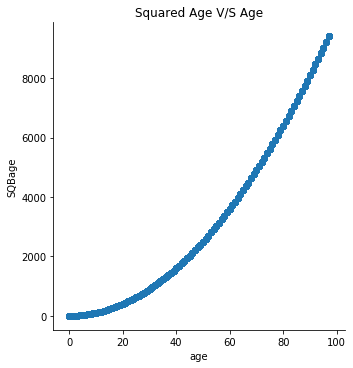

In [19]:
sns.lmplot('age', 'SQBage', data = new_df, fit_reg=False);
plt.title('Squared Age V/S Age');

As we can see these both variables are highly correlated, so we don't have to keep both the variables in data

In [20]:
# Remove all the Squared variables
new_df = new_df.drop(axis=1,labels = sqr_var)
new_df.shape

(33413, 135)

### Id Variables

These variables will be kept in the data as we would need them for identification later


In [21]:
id_var = ['Id', 'idhogar', 'Target', 'source']

### Household Variables

In [22]:
hh_var_boo = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb','pisocemento', 'pareddes', 
              'paredmad','paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 
              'pisomadera', 'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 
              'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 'sanitario2', 
              'sanitario3', 'sanitario5',   'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3', 
              'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 
              'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'tipovivi1', 'tipovivi2', 
              'tipovivi3', 'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3', 'lugar4', 
              'lugar5', 'lugar6', 'area1', 'area2']

hh_var_ordered = ['rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 'r4t3', 'v18q1', 'tamhog',
                  'tamviv','hhsize','hogar_nin', 'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_var_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

First let's subset to the heads of household and then to the household level variables.

In [23]:
head = new_df.loc[new_df['parentesco1'] == 1, :]
head = head[id_var + hh_var_boo + hh_var_cont + hh_var_ordered]
head.shape

(10307, 99)

### Superflous Household Variables
Let's take a look at the correlations between all of the household variables. If there are any that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.95 correlation

In [24]:
# Create correlation matrix
corr_matrix = head.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

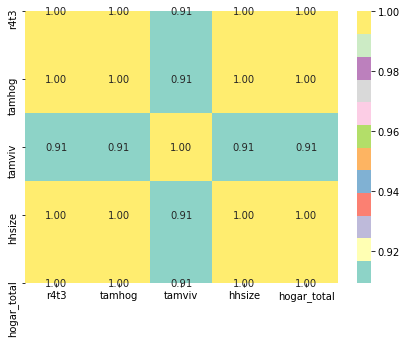

In [25]:
# Lets plot the correlation
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.Set3, fmt='.2f');

In [26]:
# Instead of droping these rows from the subset, we'll remove it from the original dataframe
new_df = new_df.drop(axis= 1, labels = ['tamhog', 'hogar_total', 'r4t3'])

In [27]:
elec = []

# Assign values
for i, row in new_df.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
new_df['elec'] = elec
new_df['elec-missing'] = new_df['elec'].isnull()

# Remove the electricity columns
new_df = new_df.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

We can see that for every value of the Target, the most common source of electricity is from one of the listed providers.

The final redundant column is area2. This means the house is in a rural zone, but it's redundant because we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.


In [29]:
new_df = new_df.drop(axis=1, labels = 'area2')

### Individual Level Variables
There are two types of individual level variables: Boolean (1 or 0 for True or False) and ordinal (discrete values with a meaningful ordering).

In [30]:
ind_var_boo = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 
               'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1', 'parentesco2',  'parentesco3', 
               'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 
               'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 
               'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone']

ind_var_ordered = ['rez_esc', 'escolari', 'age']

ind = new_df[id_var + ind_var_boo + ind_var_ordered]
ind.shape

(33413, 40)

### Superfluous Individual Variables

We can do the same process we did with the household level variables to identify any redundant individual variables. We'll focus on any variables that have an absolute magnitude of the correlation coefficient greater than 0.95.



In [31]:
#Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

This is simply the opposite of male! We can remove the male flag.



In [32]:
new_df = new_df.drop(axis = 1, labels = 'male')

Lets start the preprocessing and first would be to deal with categorical variables. We need to convert them to integer to use in the model.

In [34]:
#Divide into test and train:
df_train = new_df.loc[new_df['source']=="income_train"]
df_test = new_df.loc[new_df['source']=="income_test"]

#Drop unnecessary columns:
df_test.drop(['Id','source', 'Target'],axis=1,inplace=True)
df_train.drop(['Id','source'],axis=1,inplace=True)

#Export files as modified versions:
df_train.to_csv("train_modified.csv",index=False)
df_test.to_csv("test_modified.csv",index=False)


In [35]:
train_df = pd.read_csv('train_modified.csv')
test_df = pd.read_csv('test_modified.csv')

In [36]:
print(train_df.shape)
print(test_df.shape)

(9557, 126)
(23856, 125)


In [37]:
train_df['elec'].fillna(train_df['elec'].mean(), inplace = True)
test_df['elec'].fillna(test_df['elec'].mean(), inplace = True)

In [38]:
var_mod_train = train_df.select_dtypes(exclude=['int', 'float']).columns
var_mod_test = test_df.select_dtypes(exclude = ['int', 'float']).columns

In [39]:
#### Converting categorical columns to integer
label_encode = LabelEncoder()

var_mod_train = var_mod_train
var_mod_test = var_mod_test

for i in var_mod_train:
    train_df[i] = label_encode.fit_transform(train_df[i])
    
for i in var_mod_test:
    test_df[i] = label_encode.fit_transform(test_df[i])

In [40]:
print(train_df.shape)
print(test_df.shape)

(9557, 126)
(23856, 125)


In [41]:
x = train_df.drop(['Target'], axis=1)
y = train_df.Target

In [42]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size = 0.2, random_state = 42)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((7645, 125), (1912, 125), (7645,), (1912,))

In [43]:
feature_scale = StandardScaler()
train_x = feature_scale.fit_transform(train_x)
test_x = feature_scale.fit_transform(test_x)

### Modelling with Random Forest

In [44]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=5, n_jobs = 3, criterion = 'entropy', random_state = 42)
model = rfc.fit(train_x, train_y)
y_pred=rfc.predict(test_x)

In [45]:
rand_for_acc_train = rfc.score(train_x, train_y)
print('Random Forest Accuracy Training:', rand_for_acc_train)

Random Forest Accuracy Training: 0.6659254414650098


In [46]:
rand_for_acc_test = accuracy_score(test_y, y_pred)
print('Random Forest Accuracy Testing:', rand_for_acc_test)

Random Forest Accuracy Testing: 0.6521966527196653


In [47]:
scores = cross_val_score(rfc, x, y, cv=10)
scores

array([0.6388309 , 0.6415883 , 0.64054336, 0.63322884, 0.63769634,
       0.6565445 , 0.6408377 , 0.63664921, 0.62054507, 0.64046122])

In [48]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.64 (+/- 0.02)


In [49]:
test_pred = rfc.predict(test_df)

In [50]:
test_pred

array([4., 4., 4., ..., 4., 4., 4.])

### Above are the predictions of our test data